In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [13]:
class ANNiris(nn.Module):
    def __init__(self,nUnits,nLayers):
        super().__init__()

        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

        self.layers['input'] = nn.Linear(4,nUnits)

        for i in range(nLayers):
            self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

        self.layers['output'] = nn.Linear(nUnits,3)

    def forward(self,x):
        x = self.layers['input'](x)
        x = F.relu(x)

        for i in range(self.nLayers):
            x = self.layers[f'hidden{i}'](x)
            x = F.relu(x)

        x = self.layers['output'](x)
        return x
        

In [15]:
net = ANNiris(12,4)
net

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [31]:
def trainModel(Model):

    lossFun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(Model.parameters(),lr=0.01)

    for epochi in range(1000):

        yHat = Model(data)
        loss = lossFun(yHat,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    predictions = Model(data)
    predlabels = torch.argmax(predictions,axis=1)
    acc = 100*torch.mean((predlabels==labels).float())
    nParams = sum(p.numel() for p in Model.parameters() if p.requires_grad)

    return acc,nParams

    

In [33]:
acc,parameters = trainModel(net)
acc,parameters

(tensor(82.), 723)

In [37]:

numlayers = range(1,6)         
numunits  = np.arange(4,101,3) 

accuracies  = np.zeros((len(numunits),len(numlayers)))
totalparams = np.zeros((len(numunits),len(numlayers)))

for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    net = ANNiris(numunits[unitidx],numlayers[layeridx])
    acc,nParams = trainModel(net)
    accuracies[unitidx,layeridx] = acc

    totalparams[unitidx,layeridx] = nParams

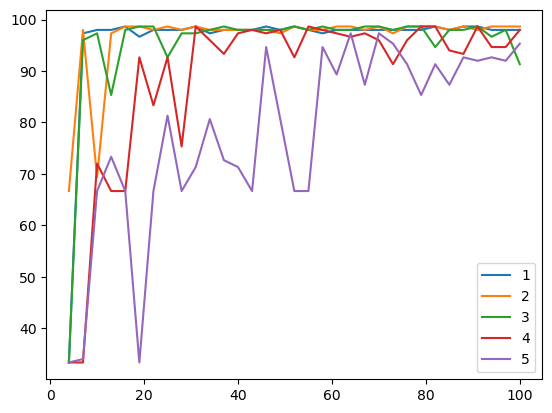

In [41]:
plt.plot(numunits,accuracies)
plt.legend(numlayers)
plt.show()

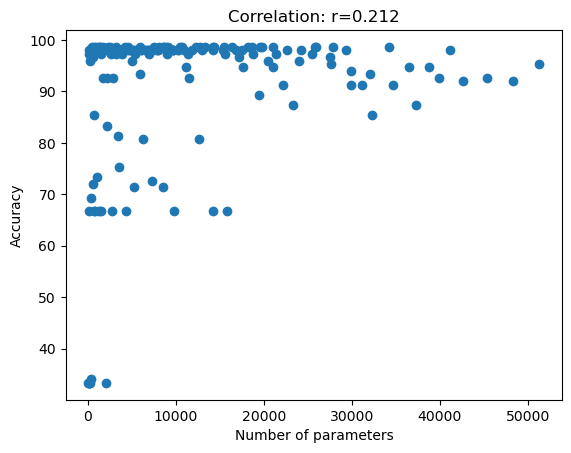

In [43]:
x = totalparams.flatten()
y = accuracies.flatten()

r = np.corrcoef(x,y)[0,1]

plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()